# Causal Influence Decouple From Their Underlying Structure In Echo State Networks.
In this notebook we're addressing a very interesting question of neuroscience: *"Does the structure of a network dictate its function?"* and for sure the debate is heated and very much alive. Here we're taking a different approach and define "function" as causal interaction of nodes instead of the conventional ways *e.g.,* correlation or co-fluctuation. But what do we mean by causal interaction? To be more clear, I'll replace interaction with influence so causal influence of a node $i$ on another node $j$ is a scalar, describing the amount of which $i$ is contributing to $j$'s activity. Imagine node $j$ is connected to three other nodes $i$, $k$, and $z$, producing a boring oscillatory signal. Now imagine we shut down $z$, looked into $j$'s activity again and found no difference. Still the same boring oscillatory signal. It's safe to assume then $j$ is not causally influenced by $z$ because by manipulating $z$ nothing really happened to $j$ (for the sake of simplicity, there's no homeostasis or plasticity or anything like that). Now imagine we perturbed (silenced) $k$ and $j$ went wild, producing a very intense high-frequency activity. This implies that $k$ had a stabilizing effect on $j$, it was keeping it away from this over-activation somehow so we can assign a *negative contribution* to $k\rightarrow{j}$. Lastly, let's say removing $i$ made $j$ silent too. This means $i$ was exciting or driving $j$ so we can assign a positive contribution to $i\rightarrow{j}$. But we first need a metric to quantify these behaviors. There are tons of options out there but we compute $j$'s "energy". If a signal is flat on zero, then it has no energy and the energy increases with the signal doing different things *e.g.,* the amplitude or the frequency goes up. Second, what we did above works for a very straight-forward connectivity. We don't know how nodes behave when the system is large and there are recurrent connections, which is the situation in the brain. If we perturb nodes one by one and track the difference in a target node then we most probably end up with wrong conclusions because of this complexity. What we need to do is to perturb all combinations of nodes, for example, all the nodes one by one, then all the pairs, all the triplets, and so on. This solves a very critical epistemic issue but produces two practical ones:

1. How to perturb all combinations of nodes? There will be millions if the system is large.
2. Even if we did, how to make sense of results derived from millions of perturbations?

Skipping all the details, Multi-perturbation Shapley value Analysis (MSA) takes care of both. It tells us what to perturb and then from that massive dataset of multi-site perturbations, it gives us a value per node that describes its causal contribution. See `Figures/Methods2.pdf` for a visual abstract of the methods.

In this notebook, we used an Echo State Network (ESN) that is a recurrent neural network model in which the hidden layer remains unaltered during training. Why do we care about alteration of the hidden layer? because we are pluging a brain-inspired connectivity pattern (a small-world graph) to it and we want to keep the weights fixed. This means we can use the exact same "connectome" and produce/analyse different neural networks from it. We trained it on a simple but non-trivial task of predicting a chaotic time-series, so the network produces a signal that we call its "behavior". We then used MSA and computed the causal contribution of all nodes to this signal's energy. After that, we did the same for each node with respect to the other nodes (like the example above but from all combinations of lesions). We did the same thing with a simpler spiking network (it's so simple that can't be trained so no behavior for lil fella) that passes spikes according to a three-step rule of Susceptible-Excited-Refractory (SER). In this network each node is Susceptible and gets Excited if its input passes a threshold, then it goes to a Refractory phase and remains silent until it gets susceptible again. Why this model tho? So we have ESN and there, each signal is doing very complicated things full of non-linearities and all that but in SER models things are simpler so we can compare them. And we did! We compared the findings from these two networks to see how differently nodes influence each other. It turned out that in ESNs they influence each other regardless of the connection weights and signs, while in SER the weights are reliable indicators of the causal influence. In other words, structure has a bigger role in SER compared to ESN. Nodes in ESN do all sorts of things to influence each other and that makes the structure-function relationship a tricky one. We think this is also the case in the brain and it might be even worse because who are we kidding, ESN is a super-abstract model of real neuronal circuits. Anyway, let's get into it.

In [1]:
# Imports, it's like greetings in Python.
import numpy as np
from scipy.stats import pearsonr
from msapy import msa, utils as ut, plottings as pl
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from echoes import ESNGenerator
from echoes.datasets import load_mackeyglasst17
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from copy import deepcopy
import networkx as nx


from ser import SER
from matplotlib.ticker import FormatStrFormatter
from scipy.ndimage import gaussian_filter1d


In [2]:
SEED = 2022
pl.set_style(font_size=8)
my_colors = ['#006685', '#3FA5C4', '#FFFFFF', '#E84653', '#BF003F']
colormap = sns.blend_palette(my_colors,as_cmap=True)

In [3]:
# Technically, the task.
mackey_ts = load_mackeyglasst17()
y_train, y_test = train_test_split(mackey_ts[:2500],
                                   train_size=2000,
                                   test_size=500,
                                   shuffle=False)

y_train_validate, y_test_validate = train_test_split(mackey_ts[:3500],
                                                     train_size=3000,
                                                     test_size=500,
                                                     shuffle=False)

In [4]:
# Constructing connectomes and defining the parameters
rng = np.random.default_rng(seed=SEED)
smallworld = nx.to_numpy_array(nx.generators.watts_strogatz_graph(36, 6, 0.4, seed=SEED))

ser_connectome = smallworld*rng.uniform(low=0.1,
                                        high=1,
                                        size=(len(smallworld),len(smallworld)))

# randomly assigning weights 50 times to have 50 ESN connectomes. This'll make the network more robust.
esn_weights = [smallworld*rng.uniform(low=-0.5,
                                      high=0.5,
                                      size=(len(smallworld),len(smallworld))) for _ in range(50)]

parameter_space = list(ParameterGrid({'radius': np.linspace(0.5, 1, 20),
                                      'W':esn_weights}))

In [5]:
esn = ESNGenerator(n_steps=500,
                   spectral_radius=None, # to be filled during the hyperparameter tuning
                   leak_rate=0.1,
                   random_state=2022,
                   W=None, # to be filled during the hyperparameter tuning
                   W_fb=rng.integers(-1,1,len(smallworld)).reshape(-1,1),
                   W_in=rng.uniform(-1,1,len(smallworld)).reshape(-1,1),
                   bias=0.001)

In [6]:
# Finding the best weights and spectral radius (hyperparameter tuning):
for parameters in tqdm(parameter_space,
                       total=len(parameter_space),
                       desc='Optimizing hyperparams: '):

    esn.spectral_radius = parameters['radius']
    esn.W=parameters['W']
    esn.fit(X=None, y=y_train)
    y_pred = esn.predict()
    parameters.update({'error': mean_squared_error(y_test, y_pred)})

optimum_params = min(parameter_space, key=lambda x: x['error']) # the combination with the minimum MSE


Optimizing hyperparams: 100%|██████████| 1000/1000 [00:33<00:00, 30.30it/s]


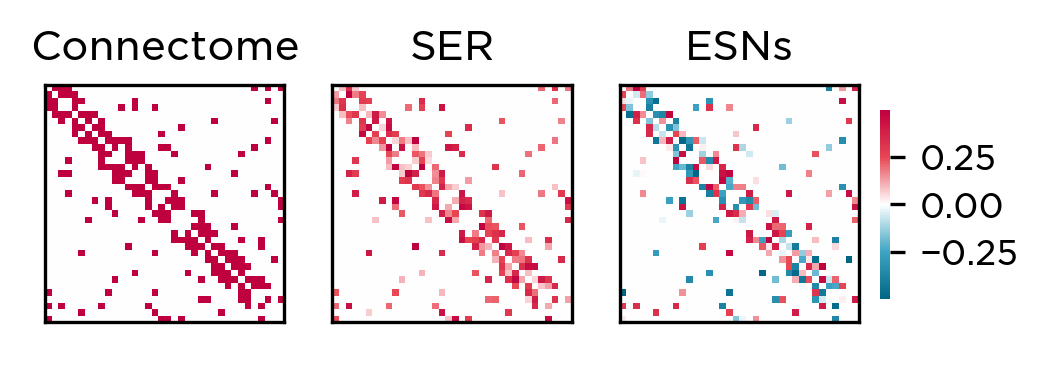

In [7]:
fig,axes = plt.subplot_mosaic([['A', 'B', 'C']],figsize=(3.5,1.05),dpi=300)

cbar_ax = fig.add_axes([.92, .2, .01, .6]) # I ended up hard coding coordinates a lot here and I know it's not nice. Not sure how to fix it yet so it's a TODO for later.

sns.heatmap(smallworld,
            square=False,center=0,xticklabels=False,yticklabels=False,
            cmap=colormap,cbar=False,ax=axes['A'])

sns.heatmap(ser_connectome,
            square=False,center=0,xticklabels=False,yticklabels=False,
            cmap=colormap,cbar=False,ax=axes['B'])

sns.heatmap(optimum_params['W'],
            square=False,center=0,xticklabels=False,yticklabels=False,
            cmap=colormap,cbar_ax = cbar_ax,ax=axes['C'])

axes['A'].title.set_text('Connectome')
axes['B'].title.set_text('SER')
axes['C'].title.set_text('ESNs')

for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)

plt.savefig(f"Topology.pdf",dpi=600,bbox_inches='tight')

In [8]:
# testing the network.
esn.spectral_radius = optimum_params['radius']
esn.W = optimum_params['W']
esn.store_states_pred=True
esn.fit(X=None, y=y_train_validate)

y_pred = esn.predict()
mse = mean_squared_error(y_test_validate, y_pred)
l2_y_pred_intact = np.linalg.norm(y_pred)
print(f'MSE: {mse:.2}, Energy: {l2_y_pred_intact:.2}')
print(f'Optimal Spectral Radius: {optimum_params["radius"]:.2}')

MSE: 0.0049, Energy: 5.1
Optimal Spectral Radius: 0.66


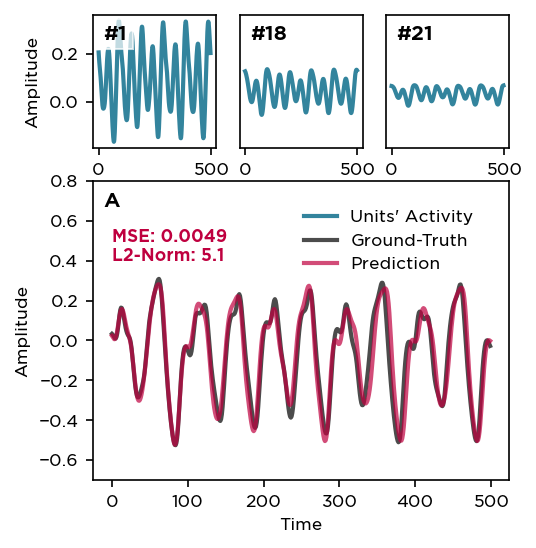

In [9]:
units = [1,18,21]

fig,axes = plt.subplot_mosaic(
    [   [f'#{units[0]}', f'#{units[1]}', f'#{units[2]}'],
        ['A', 'A', 'A'],
        ['A', 'A', 'A']
    ],figsize=(3.5,3.5),dpi=150)

axes['A'].plot(y_test_validate,color='k',alpha=0.7,label="Ground-Truth",linewidth=2)
axes['A'].plot(y_pred,color='#BF003F',alpha=0.7,label="Prediction",linewidth=2)
axes['A'].set_ylabel("Amplitude")
axes['A'].set_xlabel('Time')
axes['A'].text(0,0.4,f"MSE: {mse:.2}\nL2-Norm: {l2_y_pred_intact:.2}",fontweight='bold',color='#BF003F')
axes['A'].set_ylim(ymax=0.8,ymin = -0.7)

for index, unit in enumerate(units):
    if index == 0:
        axes[f'#{unit}'].plot(esn.states_pred_[:,unit],color='#006685',alpha=0.8,label="Units' Activity",linewidth=2)
        axes[f'#{unit}'].set_ylabel("Amplitude")

    else:
        axes[f'#{unit}'].plot(esn.states_pred_[:,unit],color='#006685',alpha=0.8,label="_nolegend_",linewidth=2)
        axes[f'#{unit}'].sharey(axes[f'#{units[0]}'])
        axes[f'#{unit}'].yaxis.set_visible(False)

for label, ax in axes.items():
    trans = mtransforms.ScaledTranslation(5/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large',fontweight='bold', verticalalignment='top', bbox=dict(facecolor='white',edgecolor='white', alpha=0.7, pad=3.0))

lines = []
labels = []
for ax in fig.axes:
    axLine, axLabel = ax.get_legend_handles_labels()
    lines.extend(axLine)
    labels.extend(axLabel)
fig.legend(lines, labels,bbox_to_anchor=(0.93, 0.65),frameon=False)
fig.tight_layout(pad=0.2)
plt.savefig(f"Activity of the Intact.pdf",dpi=600,bbox_inches='tight')

## Lesioning the ESN to compute causal contributions and influences:

In [10]:
def lesion_esn_nodes(complements, network, training_data, index):
    """
    This function lesions nodes and tracks their influences over other nodes. This is for the "causal influence decomposition" part.
    I could combine this with the one below (behavior) but I didn't (obviously)! It would be more Pythonic probably but also more complicated so less readable.
    """
    if len(complements) == len(network.W)-1:
        return 0 # every node in the network is lesioned so why bother simulating?

    lesioned_network = deepcopy(network)
    for target in complements: # setting weights to a very small number (technically zero) but not zero itself since an actual zero breaks things!
        lesioned_network.W[target] = 0.00001 # hidden layer connections
        lesioned_network.W_fb[target] = 0.00001 # feedback weights of a node to itself (from t-1 I think)
        lesioned_network.W_in[target] = 0.00001 # input weights

    lesioned_network.fit(X=None, y=training_data)
    _ = lesioned_network.predict() # we don't care about the output signal here but we need to predict to get the hidden states.
    lesioned_signal = lesioned_network.states_pred_[:, index] # we care about the behavior of the target node

    return float(np.linalg.norm(lesioned_signal)) # Euclidean norm of the output signal (its energy)


def lesion_esn_behavior(complements, network, training_data, ground_truth):
    """
    This function lesions nodes and tracks their contributions to the output signal. This is for the classic MSA part.
    """
    if len(complements) == len(network.W):
        return 0 # every node in the network is lesioned so toss a zero to your MSA oh valley of plenty.

    lesioned_network = deepcopy(network)
    for target in complements: # same as above
        lesioned_network.W[target] = 0.00001
        lesioned_network.W_fb[target] = 0.00001
        lesioned_network.W_in[target] = 0.00001

    lesioned_network.fit(X=None, y=training_data)
    y_pred = lesioned_network.predict() # contrary to the previous function, here we want the output signal.

    return float(np.linalg.norm(y_pred))


## Classic MSA: Quantifying the contribution of each node to the energy of the output signal.
The cell below performs a multi-site perturbation (around 360,000 unique combinations of nodes) on the network. For each of these combinations, we re-run the task, which means we fit and then predict the Mackey-Glass time-series. Fortunately, Echoes is very efficient and fast (kudos to Fabrizio) so it'll only take a few minutes. MSA then estimates the causal contribution of each node to the energy level of the output signal from those 360,000 experiments.

In [11]:
lesion_esn_behavior_params = {'network':esn,'training_data':y_train_validate,'ground_truth':y_test_validate}
shapley_table, causal_contributions, lesion_effects = msa.interface(multiprocessing_method='joblib',
                                                                    elements=list(range(esn.n_reservoir_)),
                                                                    n_permutations= 10_000,
                                                                    objective_function=lesion_esn_behavior,
                                                                    objective_function_params=lesion_esn_behavior_params,
                                                                    n_parallel_games=-1,
                                                                    random_seed=SEED)

Playing the games: 100%|██████████| 300131/300131 [10:37<00:00, 470.84it/s]


In [12]:
l2s = list(causal_contributions.values())
logl2s=np.log(l2s)
# This gives us an idea of how the system behaved in general given all those combinations of lesions.

/tmp/ipykernel_21470/1358174626.py:2: RuntimeWarning: divide by zero encountered in log
  logl2s=np.log(l2s)


In [13]:
shapley_sorted = ut.sorter(shapley_table) # Sorting the elements based on their contributions

In [14]:
blue_player = shapley_sorted.columns[0] # the one with the largest negative contribution
esn_unstable = deepcopy(esn)
esn_unstable.W[blue_player]=0.00001
esn_unstable.W_fb[blue_player] = 0.00001
esn_unstable.W_in[blue_player] = 0.00001

esn_unstable.fit(X=None, y=y_train_validate)

y_pred_unstable = esn_unstable.predict()
mse_unstable=mean_squared_error(y_test_validate, y_pred_unstable)
l2_y_pred_unstable = np.linalg.norm(y_pred_unstable)

In [15]:
red_player = shapley_sorted.columns[-1] # the one with the largest positive contribution
esn_stable = deepcopy(esn)
esn_stable.W[red_player]=0.00001
esn_stable.W_fb[red_player] = 0.00001
esn_stable.W_in[red_player] = 0.00001

esn_stable.fit(X=None, y=y_train_validate)

y_pred_stable = esn_stable.predict()

mse_stable=mean_squared_error(y_test_validate, y_pred_stable)
l2_y_pred_stable = np.linalg.norm(y_pred_stable)

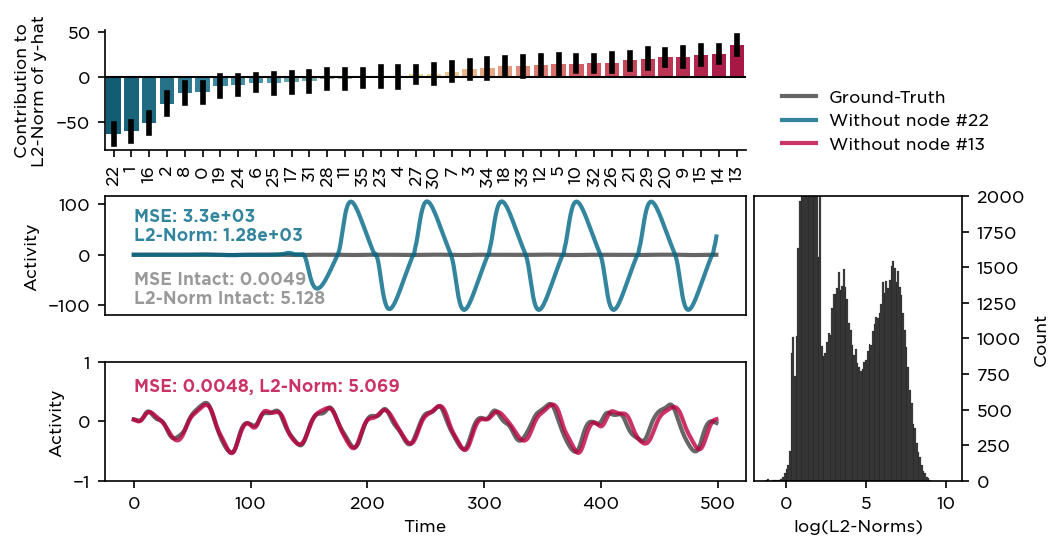

In [16]:
fig,axes = plt.subplot_mosaic(
    [['A','A','A','.'],
     ['B','B','B','D'],
     ['C','C','C','D']],figsize=(7,3.5),dpi=150)

plot_params = {"ci": 95, "orient": "v", "errcolor": "k"}


colors = pl.color_code(shapley_table=shapley_sorted)
pl.plot_shapley_ranks(shapley_table=shapley_sorted,colors=colors,ax=axes['A'],barplot_params=plot_params)
axes['A'].set_ylabel('Contribution to\nL2-Norm of y-hat')
#axes['A'].set_ylim(-100,100)
axes['A'].tick_params(axis='x', rotation=90)

axes['B'].plot(y_test_validate,color='k',alpha=0.6,label="Ground-Truth",linewidth=2)
#axes['B'].plot(y_pred,color='k',alpha=0.4,label=f"Intact",linewidth=2)
axes['B'].plot(y_pred_unstable,color='#006685',alpha=0.8,label=f"Without node #{blue_player}",linewidth=2)

axes['B'].text(0,-95,f"MSE Intact: {mse:.2}\nL2-Norm Intact: {l2_y_pred_intact:.4}",color='k',fontweight='bold',alpha=0.4)
axes['B'].text(0,30,f"MSE: {mse_unstable:.2}\nL2-Norm: {l2_y_pred_unstable:.4}",color='#006685',fontweight='bold',alpha=0.8)

axes['B'].sharex(axes['C'])
axes['B'].xaxis.set_visible(False)

axes['B'].set_ylabel('Activity')

axes['C'].plot(y_test_validate,color='k',alpha=0.6,label="_nolegend_",linewidth=2)
axes['C'].plot(y_pred_stable,color='#BF003F',alpha=0.8,label=f"Without node #{red_player}",linewidth=2)
axes['C'].set_xlabel('Time')
axes['C'].set_ylabel('Activity')
axes['C'].set_ylim(ymax=1,ymin = -1)

axes['C'].text(0,0.5,f"MSE: {mse_stable:.2}, L2-Norm: {l2_y_pred_stable:.4}",color='#BF003F',fontweight='bold',alpha=0.8)
sns.histplot(data=logl2s,bins=100,kde=False,color='k',ax=axes['D'])
axes['D'].set_ylim(ymax=2_000,ymin = 0)
axes['D'].set_xlim(xmax=11,xmin = -2)

axes['D'].yaxis.tick_right()
axes['D'].yaxis.set_label_position("right")
axes['D'].set_xlabel('log(L2-Norms)')
fig.legend(bbox_to_anchor=(0.95, 0.89),frameon=False)

fig.tight_layout(pad=0.5)
plt.savefig(f"Behavior.pdf",dpi=600,bbox_inches='tight')

As you can see above, the nodes are now ranked according to their causal contributions to the output signal. The warm ones are those who, on average, when removed, the output signal ended up with a lower energy and the otherway around goes for the ones on the left side (of the top panel). You can see it in action actually, removing the nodes 22 and 13 resulted in a higher and lower energy compared to the intact network.

In [17]:
print(f"Contributions missed: {(np.linalg.norm(y_pred) - shapley_sorted.mean().sum()):.2}")
# This is a sanity check. The contributions should add up to the behavior of the intact system (energy of the network when it's not lesioned). Here the difference is super small so MSA did a good job.

Contributions missed: -2.3e-14


## Causal Influence Decomposition: Quantifying the causal influence of each node on the others.
Here, we will iteratively perform MSA on every node and track the changes in the activity of a target node. It's basically what we did above but for each iteration, we leave one node out and assume its activity to be the "behavior". Then we do the multi-site perturbation of all other nodes (N-1 nodes) and MSA quantifies their contributions to the target node. Do this for all nodes gives us a "causal influence connectivity" in which $C(i,j)$ indicates the causal influence of $i$ on $j$. Note that we can check for a very cool thing. We have the actual connectome, the connectivity matrix that tells us who is linked to whom and with what weight. We also have this matrix that tells us removing which node influenced another node and how much. Comparing these two tells us if nodes influenced only their connected neighbors or it goes beyond that. For example, imagine there is no actual connection between $i$ and $j$ while removing $i$ made $j$ unstable. How? probably via other routes (indirectly). So if this happens it means nodes influence each other even if they are not actually connected.

In [18]:
lesion_esn_nodes_params = {'network':esn,'training_data':y_train_validate}

causal_influence_matrix = msa.estimate_causal_influences(network_connectome= esn.W,
                                                         objective_function=lesion_esn_nodes,
                                                         objective_function_params=lesion_esn_nodes_params,
                                                         n_permutations=5_000) # this takes time so we do 35000 (N-1*1000) combinations for each node.
causal_influence_matrix = causal_influence_matrix.T

working on the node number 0 from 36 nodes.


Playing the games: 100%|██████████| 147706/147706 [05:18<00:00, 463.18it/s]


working on the node number 1 from 36 nodes.


Playing the games: 100%|██████████| 147726/147726 [05:09<00:00, 476.95it/s]


working on the node number 2 from 36 nodes.


Playing the games: 100%|██████████| 147670/147670 [05:25<00:00, 453.40it/s]


working on the node number 3 from 36 nodes.


Playing the games: 100%|██████████| 147602/147602 [05:17<00:00, 464.98it/s]


working on the node number 4 from 36 nodes.


Playing the games: 100%|██████████| 147739/147739 [05:22<00:00, 458.11it/s]


working on the node number 5 from 36 nodes.


Playing the games: 100%|██████████| 147696/147696 [05:23<00:00, 456.29it/s]


working on the node number 6 from 36 nodes.


Playing the games: 100%|██████████| 147686/147686 [05:14<00:00, 469.95it/s]


working on the node number 7 from 36 nodes.


Playing the games: 100%|██████████| 147690/147690 [05:17<00:00, 464.76it/s]


working on the node number 8 from 36 nodes.


Playing the games: 100%|██████████| 147681/147681 [05:20<00:00, 460.86it/s]


working on the node number 9 from 36 nodes.


Playing the games: 100%|██████████| 147742/147742 [05:24<00:00, 455.68it/s]


working on the node number 10 from 36 nodes.


Playing the games: 100%|██████████| 147661/147661 [05:26<00:00, 452.42it/s]


working on the node number 11 from 36 nodes.


Playing the games: 100%|██████████| 147695/147695 [05:19<00:00, 461.90it/s]


working on the node number 12 from 36 nodes.


Playing the games: 100%|██████████| 147664/147664 [05:32<00:00, 443.78it/s]


working on the node number 13 from 36 nodes.


Playing the games: 100%|██████████| 147666/147666 [05:27<00:00, 450.97it/s]


working on the node number 14 from 36 nodes.


Playing the games: 100%|██████████| 147661/147661 [05:17<00:00, 464.95it/s]


working on the node number 15 from 36 nodes.


Playing the games: 100%|██████████| 147659/147659 [05:20<00:00, 460.51it/s]


working on the node number 16 from 36 nodes.


Playing the games: 100%|██████████| 147751/147751 [05:15<00:00, 468.68it/s]


working on the node number 17 from 36 nodes.


Playing the games: 100%|██████████| 147749/147749 [05:15<00:00, 468.16it/s]


working on the node number 18 from 36 nodes.


Playing the games: 100%|██████████| 147677/147677 [05:13<00:00, 471.72it/s]


working on the node number 19 from 36 nodes.


Playing the games: 100%|██████████| 147670/147670 [05:21<00:00, 459.57it/s]


working on the node number 20 from 36 nodes.


Playing the games: 100%|██████████| 147723/147723 [05:24<00:00, 455.79it/s]


working on the node number 21 from 36 nodes.


Playing the games: 100%|██████████| 147670/147670 [05:20<00:00, 460.09it/s]


working on the node number 22 from 36 nodes.


Playing the games: 100%|██████████| 147663/147663 [05:13<00:00, 470.44it/s]


working on the node number 23 from 36 nodes.


Playing the games: 100%|██████████| 147684/147684 [05:21<00:00, 459.40it/s]


working on the node number 24 from 36 nodes.


Playing the games: 100%|██████████| 147664/147664 [05:23<00:00, 455.86it/s]


working on the node number 25 from 36 nodes.


Playing the games: 100%|██████████| 147668/147668 [05:14<00:00, 469.76it/s]


working on the node number 26 from 36 nodes.


Playing the games: 100%|██████████| 147691/147691 [05:14<00:00, 470.11it/s]


working on the node number 27 from 36 nodes.


Playing the games: 100%|██████████| 147654/147654 [05:16<00:00, 466.28it/s]


working on the node number 28 from 36 nodes.


Playing the games: 100%|██████████| 147726/147726 [05:14<00:00, 469.06it/s]


working on the node number 29 from 36 nodes.


Playing the games: 100%|██████████| 147703/147703 [05:21<00:00, 459.66it/s]


working on the node number 30 from 36 nodes.


Playing the games: 100%|██████████| 147716/147716 [05:24<00:00, 455.55it/s]


working on the node number 31 from 36 nodes.


Playing the games: 100%|██████████| 147641/147641 [05:21<00:00, 459.41it/s]


working on the node number 32 from 36 nodes.


Playing the games: 100%|██████████| 147676/147676 [05:14<00:00, 470.08it/s]


working on the node number 33 from 36 nodes.


Playing the games: 100%|██████████| 147765/147765 [05:16<00:00, 466.19it/s]


working on the node number 34 from 36 nodes.


Playing the games: 100%|██████████| 147693/147693 [05:20<00:00, 460.27it/s]


working on the node number 35 from 36 nodes.


Playing the games: 100%|██████████| 147670/147670 [05:21<00:00, 459.16it/s]


In [19]:
positive_signed_degree = (causal_influence_matrix>0).sum()/len(causal_influence_matrix)
shapley_sorted_by_index = ut.sorter(shapley_table=shapley_table,ascending=True).mean()
corr_with_behavior = pearsonr(positive_signed_degree,shapley_sorted_by_index)

direct = causal_influence_matrix.where(esn.W!=0)
indirect = causal_influence_matrix.where(esn.W==0)

/tmp/ipykernel_21470/1041589734.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=0.8)


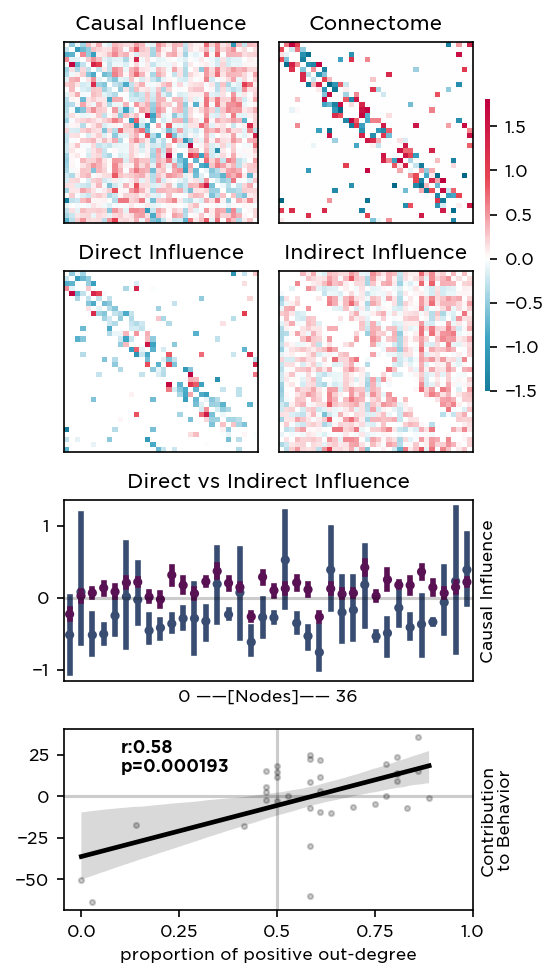

In [20]:
vmax = causal_influence_matrix.max().max()
fig,axes = plt.subplot_mosaic(
    [['A', 'B',],
     ['C', 'D',],
     ['E', 'E',],
     ['F', 'F',]],figsize=(3.5,6.5),dpi=150)
cbar_ax = fig.add_axes([0.92, .6, .01, .3])

sns.heatmap(causal_influence_matrix,
            center=0,xticklabels=False,yticklabels=False,
            cmap=colormap,cbar_ax = cbar_ax,ax=axes['A'],vmax=vmax)
sns.heatmap(esn.W,center=0,xticklabels=False,yticklabels=False,
            cmap=colormap,cbar_kws={"shrink": .8},ax=axes['B'],cbar=False)

sns.heatmap(direct,
            center=0,xticklabels=False,yticklabels=False,
            cmap=colormap,cbar=False,ax=axes['C'],vmax=vmax)
sns.heatmap(indirect,
            center=0,xticklabels=False,yticklabels=False,
            cmap=colormap,cbar=False,ax=axes['D'],vmax=vmax)

sns.pointplot(data=direct,color='#394D73',alpha=0.8,ci=95,join=False,ax=axes['E'],scale=0.5)
sns.pointplot(data=indirect,color='#591154',alpha=0.8,ci=95,join=False,ax=axes['E'],scale=0.5)

axes['A'].title.set_text('Causal Influence')
axes['B'].title.set_text('Connectome')
axes['C'].title.set_text('Direct Influence')
axes['D'].title.set_text('Indirect Influence')
axes['E'].title.set_text('Direct vs Indirect Influence')


axes['E'].set_xticks([])
axes['E'].set_xlabel(f'0 ——[Nodes]—— {esn.n_reservoir_}')
axes['E'].set_ylabel('Causal Influence')
axes['E'].yaxis.set_label_position("right")
axes['E'].axhline(0,alpha=0.2,c='k')


sns.regplot(x=positive_signed_degree,y=shapley_sorted_by_index,color='k',ax = axes['F'],scatter_kws={"s": 6,"alpha":0.2,"color":"k"})
axes['F'].axhline(0,alpha=0.2,c='k')
axes['F'].axvline(0.5,alpha=0.2,c='k')
axes['F'].set_xlabel("proportion of positive out-degree")
axes['F'].set_ylabel("Contribution\nto Behavior")
axes['F'].text(0.1,15,f"r:{corr_with_behavior[0]:.2}\np={corr_with_behavior[1]:.3}",fontweight='bold')
axes['F'].yaxis.set_label_position("right")
axes['F'].set_xticks(np.linspace(0,1,5))
axes['F'].set_xticklabels([str(i) for i in np.linspace(0,1,5)])
for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)
fig.tight_layout(pad=0.8)

plt.savefig(f"ESN Causal Influences.pdf",dpi=600,bbox_inches='tight')

As you see above, lots of things are happening indirectly. Even more interestingly, most direct connections have negative contributions, which means removing that node, on average, made the other unstable so the direct connections have a stabilizing role. The fact that the indirect connections are red then is very cool since it means whenever we removed some node, its neighbors became unstable (blue-direct connections) while some other nodes far away from it became less active. It's still not clear why and how this happens so we should dig deeper later.

## Causal Influence Decomposition of a simpler neural network.
Below we do the same analysis but this time on an SER model. Here the network is simple and can't really learn anything so we focus on the inner dynamics. Briefly, the signal here is a spike and it propagates through the network. To make things comparable, we convolve the spike-train with a Gaussian kernel and then compute energies and all those.

In [21]:
ser_model = SER(n_steps=500,
                prop_e=.1,
                prop_s=.5,
                threshold=.6,
                prob_recovery=.3,
                prob_spont_act=.005)
intact_events = ser_model.run(adj_mat=ser_connectome)
intact_events[intact_events == -1] = -0.001
intact_bold = gaussian_filter1d(intact_events,10)

In [22]:
def lesion_ser_nodes(complements, connectome, index):
    if len(complements) == len(connectome)-1:
        return 0

    lesioned_connectome = connectome.copy()
    for target in complements:
        lesioned_connectome[target] = 0 # here zero doesn't break things so there's no need for using very small numbers.

    lesioned_events = ser_model.run(adj_mat=lesioned_connectome)
    lesioned_events[lesioned_events == -1] = -0.1 # changing the refractory events from -1 to -0.1 otherwise the convolution would make the signal have a mostly negative amplitude.
    lesioned_smooth = gaussian_filter1d(lesioned_events,10)
    lesioned_signal = lesioned_smooth[index,:]
    return float(np.linalg.norm(lesioned_signal))


In [23]:
causal_influence_matrix_ser = msa.estimate_causal_influences(network_connectome= ser_connectome,
                                                         objective_function=lesion_ser_nodes,
                                                         objective_function_params={"connectome":ser_connectome},
                                                         n_permutations=5_000)
causal_influence_matrix_ser = causal_influence_matrix_ser.T

working on the node number 0 from 36 nodes.


Playing the games: 100%|██████████| 147735/147735 [00:34<00:00, 4226.72it/s]


working on the node number 1 from 36 nodes.


Playing the games: 100%|██████████| 147657/147657 [00:35<00:00, 4160.01it/s]


working on the node number 2 from 36 nodes.


Playing the games: 100%|██████████| 147644/147644 [00:34<00:00, 4221.38it/s]


working on the node number 3 from 36 nodes.


Playing the games: 100%|██████████| 147680/147680 [00:34<00:00, 4225.74it/s]


working on the node number 4 from 36 nodes.


Playing the games: 100%|██████████| 147724/147724 [00:36<00:00, 4100.15it/s]


working on the node number 5 from 36 nodes.


Playing the games: 100%|██████████| 147662/147662 [00:36<00:00, 4028.13it/s]


working on the node number 6 from 36 nodes.


Playing the games: 100%|██████████| 147693/147693 [00:35<00:00, 4198.55it/s]


working on the node number 7 from 36 nodes.


Playing the games: 100%|██████████| 147752/147752 [00:35<00:00, 4208.58it/s]


working on the node number 8 from 36 nodes.


Playing the games: 100%|██████████| 147681/147681 [00:35<00:00, 4204.42it/s]


working on the node number 9 from 36 nodes.


Playing the games: 100%|██████████| 147613/147613 [00:35<00:00, 4187.79it/s]


working on the node number 10 from 36 nodes.


Playing the games: 100%|██████████| 147663/147663 [00:35<00:00, 4200.01it/s]


working on the node number 11 from 36 nodes.


Playing the games: 100%|██████████| 147679/147679 [00:35<00:00, 4174.50it/s]


working on the node number 12 from 36 nodes.


Playing the games: 100%|██████████| 147715/147715 [00:35<00:00, 4179.23it/s]


working on the node number 13 from 36 nodes.


Playing the games: 100%|██████████| 147740/147740 [00:35<00:00, 4177.19it/s]


working on the node number 14 from 36 nodes.


Playing the games: 100%|██████████| 147721/147721 [00:35<00:00, 4186.91it/s]


working on the node number 15 from 36 nodes.


Playing the games: 100%|██████████| 147617/147617 [00:35<00:00, 4185.61it/s]


working on the node number 16 from 36 nodes.


Playing the games: 100%|██████████| 147661/147661 [00:35<00:00, 4162.80it/s]


working on the node number 17 from 36 nodes.


Playing the games: 100%|██████████| 147780/147780 [00:35<00:00, 4183.88it/s]


working on the node number 18 from 36 nodes.


Playing the games: 100%|██████████| 147679/147679 [00:35<00:00, 4165.38it/s]


working on the node number 19 from 36 nodes.


Playing the games: 100%|██████████| 147671/147671 [00:35<00:00, 4164.28it/s]


working on the node number 20 from 36 nodes.


Playing the games: 100%|██████████| 147721/147721 [00:35<00:00, 4160.34it/s]


working on the node number 21 from 36 nodes.


Playing the games: 100%|██████████| 147728/147728 [00:35<00:00, 4158.84it/s]


working on the node number 22 from 36 nodes.


Playing the games: 100%|██████████| 147673/147673 [00:35<00:00, 4147.84it/s]


working on the node number 23 from 36 nodes.


Playing the games: 100%|██████████| 147722/147722 [00:35<00:00, 4159.21it/s]


working on the node number 24 from 36 nodes.


Playing the games: 100%|██████████| 147678/147678 [00:35<00:00, 4140.30it/s]


working on the node number 25 from 36 nodes.


Playing the games: 100%|██████████| 147752/147752 [00:35<00:00, 4144.46it/s]


working on the node number 26 from 36 nodes.


Playing the games: 100%|██████████| 147671/147671 [00:35<00:00, 4139.56it/s]


working on the node number 27 from 36 nodes.


Playing the games: 100%|██████████| 147783/147783 [00:35<00:00, 4148.39it/s]


working on the node number 28 from 36 nodes.


Playing the games: 100%|██████████| 147633/147633 [00:35<00:00, 4117.27it/s]


working on the node number 29 from 36 nodes.


Playing the games: 100%|██████████| 147640/147640 [00:36<00:00, 4076.72it/s]


working on the node number 30 from 36 nodes.


Playing the games: 100%|██████████| 147688/147688 [00:37<00:00, 3966.61it/s]


working on the node number 31 from 36 nodes.


Playing the games: 100%|██████████| 147680/147680 [00:35<00:00, 4138.38it/s]


working on the node number 32 from 36 nodes.


Playing the games: 100%|██████████| 147715/147715 [00:35<00:00, 4135.83it/s]


working on the node number 33 from 36 nodes.


Playing the games: 100%|██████████| 147715/147715 [00:35<00:00, 4132.85it/s]


working on the node number 34 from 36 nodes.


Playing the games: 100%|██████████| 147769/147769 [00:35<00:00, 4129.15it/s]


working on the node number 35 from 36 nodes.


Playing the games: 100%|██████████| 147643/147643 [00:35<00:00, 4120.83it/s]


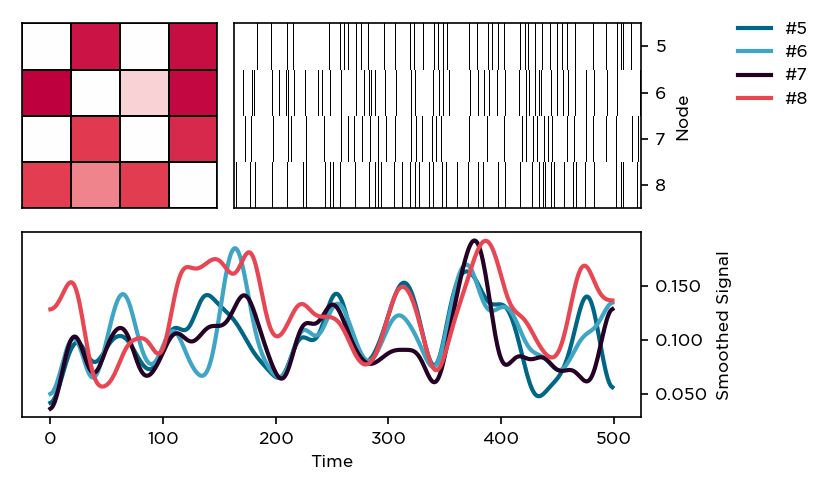

In [24]:
adjusted_colors = ['#006685', '#3FA5C4', '#260126', '#E84653', '#BF003F']

fig,axes = plt.subplot_mosaic(
    [['A','B','B'],
     ['D','D','D']],figsize=(5,3.2),dpi=150)
pr = [5,9]
sns.heatmap(ser_connectome[pr[0]:pr[1],pr[0]:pr[1]],
            square=False,center=0,xticklabels=False,yticklabels=False,
            cmap=colormap,cbar=False,ax=axes['A'],linewidths=0.1, linecolor='k')

sns.heatmap(intact_events[pr[0]:pr[1],:],xticklabels=False,yticklabels=False,cmap='binary',cbar=False,ax=axes['B'])
axes['B'].set_yticks(np.arange(4)+0.5)
axes['B'].set_yticklabels(np.arange(pr[0],pr[1]))
axes['B'].yaxis.tick_right()
axes['B'].set_ylabel('Node')
axes['B'].yaxis.set_label_position("right")

for index, signal in enumerate(range(pr[0],pr[1])):
    axes['D'].plot(intact_bold[signal,:].T,color=adjusted_colors[index],label=f"#{index+pr[0]}",linewidth=2)
axes['D'].set_xlabel('Time')
axes['D'].set_ylabel('Smoothed Signal')
axes['D'].yaxis.set_major_formatter(FormatStrFormatter("%.3f"))
axes['D'].yaxis.tick_right()
axes['D'].yaxis.set_label_position("right")
for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)


fig.tight_layout(pad=1.0)
fig.legend(bbox_to_anchor=(1.1, 1),frameon=False)

plt.savefig(f"SER intact.pdf",dpi=600,bbox_inches='tight')

# can't fix the random seed here so the figures will be different every time, but not substantially.

In [25]:
ser_direct = causal_influence_matrix_ser.where(ser_connectome!=0)

In [26]:
baseline_esn = deepcopy(esn)

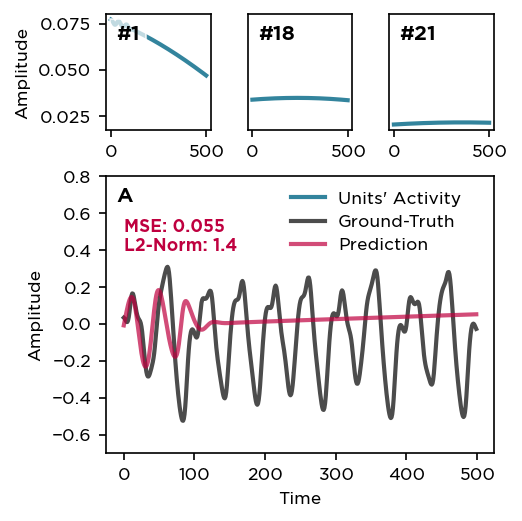

In [27]:
baseline_esn.spectral_radius = optimum_params['radius']
baseline_esn.W = optimum_params['W']
baseline_esn.leak_rate=0.001
baseline_esn.store_states_pred=True
baseline_esn.fit(X=None, y=y_train_validate)


y_pred = baseline_esn.predict()
mse=mean_squared_error(y_test_validate, y_pred)
l2_y_pred_broken = np.linalg.norm(y_pred)


units = [1,18,21]
fig,axes = plt.subplot_mosaic(
    [   [f'#{units[0]}', f'#{units[1]}', f'#{units[2]}'],
        ['A', 'A', 'A'],
        ['A', 'A', 'A']
    ],figsize=(3.5,3.5),dpi=150)
axes['A'].plot(y_test_validate,color='k',alpha=0.7,label="Ground-Truth",linewidth=2)
axes['A'].plot(y_pred,color='#BF003F',alpha=0.7,label="Prediction",linewidth=2)
axes['A'].set_ylabel("Amplitude")
axes['A'].set_xlabel('Time')

axes['A'].text(0,0.4,f"MSE: {mse:.2}\nL2-Norm: {l2_y_pred_broken:.2}",fontweight='bold',color='#BF003F')
axes['A'].set_ylim(ymax=0.8,ymin = -0.7)
for index, unit in enumerate(units):
    if index == 0:
        axes[f'#{unit}'].plot(baseline_esn.states_pred_[:,unit],color='#006685',alpha=0.8,label="Units' Activity",linewidth=2)
        axes[f'#{unit}'].set_ylabel("Amplitude")

    else:
        axes[f'#{unit}'].plot(baseline_esn.states_pred_[:,unit],color='#006685',alpha=0.8,label="_nolegend_",linewidth=2)
        axes[f'#{unit}'].sharey(axes[f'#{units[0]}'])
        axes[f'#{unit}'].yaxis.set_visible(False)



for label, ax in axes.items():
    trans = mtransforms.ScaledTranslation(5/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large',fontweight='bold', verticalalignment='top', bbox=dict(facecolor='white',edgecolor='white', alpha=0.7, pad=3.0))

lines = []
labels = []
for ax in fig.axes:
    axLine, axLabel = ax.get_legend_handles_labels()
    lines.extend(axLine)
    labels.extend(axLabel)
fig.legend(lines, labels,bbox_to_anchor=(0.91, 0.66),frameon=False)
fig.tight_layout(pad=1.0)
#fig.legend(bbox_to_anchor=(0.97, 0.5),frameon=False,handletextpad=0.01)
plt.savefig(f"Baseline_ESN.pdf",dpi=600,bbox_inches='tight')

In [28]:
lesion_baseline_nodes_params = {'network':baseline_esn,'training_data':y_train_validate}
causal_influence_matrix_baseline = msa.estimate_causal_influences(network_connectome= baseline_esn.W,
                                                                  objective_function=lesion_esn_nodes,
                                                                  objective_function_params=lesion_baseline_nodes_params,
                                                                  n_permutations=1_000)
causal_influence_matrix_baseline = causal_influence_matrix_baseline.T

working on the node number 0 from 36 nodes.


Playing the games: 100%|██████████| 30900/30900 [01:11<00:00, 431.44it/s]


working on the node number 1 from 36 nodes.


Playing the games: 100%|██████████| 30892/30892 [01:11<00:00, 430.42it/s]


working on the node number 2 from 36 nodes.


Playing the games: 100%|██████████| 30897/30897 [01:09<00:00, 442.96it/s]


working on the node number 3 from 36 nodes.


Playing the games: 100%|██████████| 30853/30853 [01:09<00:00, 443.45it/s]


working on the node number 4 from 36 nodes.


Playing the games: 100%|██████████| 30858/30858 [01:09<00:00, 444.37it/s]


working on the node number 5 from 36 nodes.


Playing the games: 100%|██████████| 30849/30849 [01:09<00:00, 442.13it/s]


working on the node number 6 from 36 nodes.


Playing the games: 100%|██████████| 30892/30892 [01:09<00:00, 441.37it/s]


working on the node number 7 from 36 nodes.


Playing the games: 100%|██████████| 30886/30886 [01:11<00:00, 431.09it/s]


working on the node number 8 from 36 nodes.


Playing the games: 100%|██████████| 30895/30895 [01:11<00:00, 432.73it/s]


working on the node number 9 from 36 nodes.


Playing the games: 100%|██████████| 30869/30869 [01:09<00:00, 443.15it/s]


working on the node number 10 from 36 nodes.


Playing the games: 100%|██████████| 30879/30879 [01:12<00:00, 425.65it/s]


working on the node number 11 from 36 nodes.


Playing the games: 100%|██████████| 30881/30881 [01:11<00:00, 429.25it/s]


working on the node number 12 from 36 nodes.


Playing the games: 100%|██████████| 30848/30848 [01:11<00:00, 432.25it/s]


working on the node number 13 from 36 nodes.


Playing the games: 100%|██████████| 30859/30859 [01:09<00:00, 442.79it/s]


working on the node number 14 from 36 nodes.


Playing the games: 100%|██████████| 30876/30876 [01:09<00:00, 443.92it/s]


working on the node number 15 from 36 nodes.


Playing the games: 100%|██████████| 30877/30877 [01:09<00:00, 442.22it/s]


working on the node number 16 from 36 nodes.


Playing the games: 100%|██████████| 30879/30879 [01:11<00:00, 432.54it/s]


working on the node number 17 from 36 nodes.


Playing the games: 100%|██████████| 30870/30870 [01:11<00:00, 433.20it/s]


working on the node number 18 from 36 nodes.


Playing the games: 100%|██████████| 30847/30847 [01:11<00:00, 432.09it/s]


working on the node number 19 from 36 nodes.


Playing the games: 100%|██████████| 30880/30880 [01:11<00:00, 429.38it/s]


working on the node number 20 from 36 nodes.


Playing the games: 100%|██████████| 30889/30889 [01:10<00:00, 437.73it/s]


working on the node number 21 from 36 nodes.


Playing the games: 100%|██████████| 30887/30887 [01:11<00:00, 429.52it/s]


working on the node number 22 from 36 nodes.


Playing the games: 100%|██████████| 30853/30853 [01:10<00:00, 439.48it/s]


working on the node number 23 from 36 nodes.


Playing the games: 100%|██████████| 30845/30845 [01:09<00:00, 441.41it/s]


working on the node number 24 from 36 nodes.


Playing the games: 100%|██████████| 30894/30894 [01:12<00:00, 424.22it/s]


working on the node number 25 from 36 nodes.


Playing the games: 100%|██████████| 30870/30870 [01:11<00:00, 431.69it/s]


working on the node number 26 from 36 nodes.


Playing the games: 100%|██████████| 30904/30904 [01:10<00:00, 438.55it/s]


working on the node number 27 from 36 nodes.


Playing the games: 100%|██████████| 30841/30841 [01:11<00:00, 429.29it/s]


working on the node number 28 from 36 nodes.


Playing the games: 100%|██████████| 30872/30872 [01:10<00:00, 439.88it/s]


working on the node number 29 from 36 nodes.


Playing the games: 100%|██████████| 30842/30842 [01:12<00:00, 427.93it/s]


working on the node number 30 from 36 nodes.


Playing the games: 100%|██████████| 30844/30844 [01:09<00:00, 441.50it/s]


working on the node number 31 from 36 nodes.


Playing the games: 100%|██████████| 30852/30852 [01:11<00:00, 431.20it/s]


working on the node number 32 from 36 nodes.


Playing the games: 100%|██████████| 30850/30850 [01:11<00:00, 429.51it/s]


working on the node number 33 from 36 nodes.


Playing the games: 100%|██████████| 30891/30891 [01:12<00:00, 428.99it/s]


working on the node number 34 from 36 nodes.


Playing the games: 100%|██████████| 30850/30850 [01:11<00:00, 429.28it/s]


working on the node number 35 from 36 nodes.


Playing the games: 100%|██████████| 30889/30889 [01:12<00:00, 428.83it/s]


In [29]:
esn_direct_broken = causal_influence_matrix_baseline.where(esn.W!=0)

In [30]:
ser_corr = pearsonr(ser_connectome.flatten(),ser_direct.fillna(0).stack().values)

esn_corr = pearsonr(np.abs(esn.W.flatten()),direct.fillna(0).stack().values)
esn_broken_corr = pearsonr(np.abs(esn.W.flatten()),esn_direct_broken.fillna(0).stack().values)
print(f"structure-function coupling in the ESN: pearson's r:{esn_corr[0]}, p={esn_corr[1]}")
print(f"structure-function coupling in the broken ESN: pearson's r:{esn_broken_corr[0]}, p={esn_broken_corr[1]}")
print(f"structure-function coupling in the SER: pearson's r:{ser_corr[0]}, p={ser_corr[1]}")


structure-function coupling in the ESN: pearson's r:-0.13679440033908538, p=7.688994530094858e-07
structure-function coupling in the broken ESN: pearson's r:-0.19701654319477835, p=8.306509670931018e-13
structure-function coupling in the SER: pearson's r:0.6540024641243332, p=5.046469966438022e-159


/tmp/ipykernel_21470/1533772873.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=0.5)


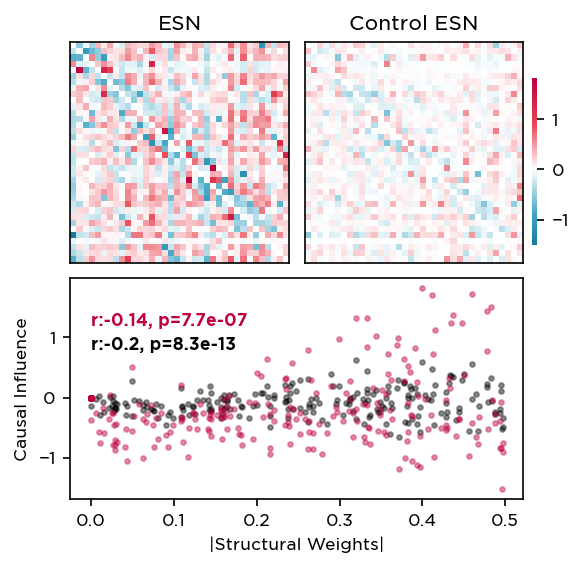

In [31]:
fig,axes = plt.subplot_mosaic(
    [['A','B'],
     ['C','C']],figsize=(3.5,3.7),dpi=150)
cbar_ax = fig.add_axes([1, .57, .01, .3])
vmax = causal_influence_matrix.max().max()
axes['A'].title.set_text("ESN")
axes['B'].title.set_text("Control ESN")

sns.heatmap(causal_influence_matrix,xticklabels=False,yticklabels=False,
            cmap=colormap,ax=axes['A'],center=0,cbar_ax = cbar_ax,vmax=vmax)
sns.heatmap(causal_influence_matrix_baseline,xticklabels=False,yticklabels=False,
            cmap=colormap,cbar_kws={"shrink": .8},cbar=False,ax=axes['B'],center=0,vmax=vmax)

sns.regplot(x=np.abs(esn.W.flatten()),y=esn_direct_broken.fillna(0).stack().values,ax=axes['C'],
            label="ESN Broken",scatter_kws={"s": 5,"alpha":0.4,"color":'k'},color='k',fit_reg=False)
sns.regplot(x=np.abs(esn.W.flatten()),y=direct.fillna(0).stack().values,ax=axes['C'], label="ESN",
            scatter_kws={"s": 5,"alpha":0.4,"color":"#BF003F"},color='#BF003F',fit_reg=False )



axes['C'].text(0,1.2,f"r:{esn_corr[0]:.2}, p={esn_corr[1]:.2}",fontweight='bold',color='#BF003F')
axes['C'].text(0,0.8,f"r:{esn_broken_corr[0]:.2}, p={esn_broken_corr[1]:.2}",fontweight='bold',color='k')
axes['C'].set_xlabel('|Structural Weights|')
axes['C'].set_ylabel('Causal Influence')

for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)


fig.tight_layout(pad=0.5)
#fig.legend(bbox_to_anchor=(0.97, 0.5),frameon=False,handletextpad=0.01)

plt.savefig(f"Weights vs CI.pdf",dpi=600,bbox_inches='tight')

In [32]:
lesion_esn_behavior_params = {'network':baseline_esn,'training_data':y_train_validate,'ground_truth':y_test_validate}
shapley_table_baseline, _, _ = msa.interface(multiprocessing_method='joblib',
                                                                    elements=list(range(baseline_esn.n_reservoir_)),
                                                                    n_permutations= 10_000,
                                                                    objective_function=lesion_esn_behavior,
                                                                    objective_function_params=lesion_esn_behavior_params,
                                                                    n_parallel_games=-1,
                                                                    random_seed=SEED)

Playing the games: 100%|██████████| 300131/300131 [10:40<00:00, 468.77it/s]


In [33]:
shapley_sorted_baseline = ut.sorter(shapley_table_baseline)

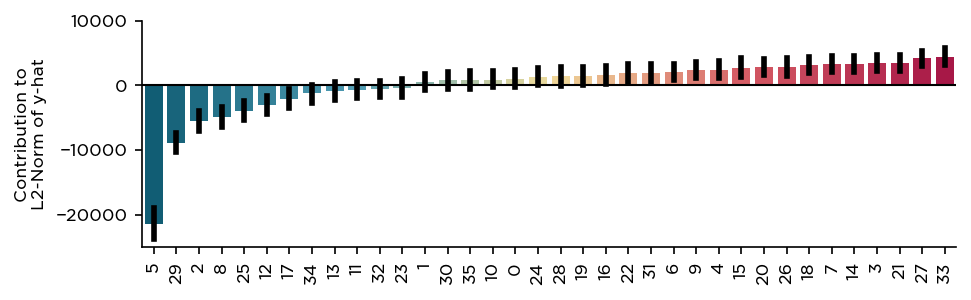

In [34]:
fig,axes = plt.subplot_mosaic([['A']],figsize=(7,2),dpi=150)
pl.plot_shapley_ranks(shapley_table=shapley_sorted_baseline,colors=colors,ax=axes['A'],barplot_params=plot_params)

axes['A'].set_ylabel('Contribution to\nL2-Norm of y-hat')
axes['A'].set_ylim(-25_000,10_000)
axes['A'].tick_params(axis='x', rotation=90)
plt.savefig(f"baseline_behavior.pdf",dpi=600,bbox_inches='tight')

In [35]:
baseline_positive_signed_degree = (causal_influence_matrix_baseline>0).sum()/len(causal_influence_matrix_baseline)
baseline_shapley_sorted_by_index = ut.sorter(shapley_table=shapley_table_baseline,ascending=True).mean()
baseline_corr_with_behavior = pearsonr(baseline_positive_signed_degree,baseline_shapley_sorted_by_index)
baseline_vs_intact = pearsonr(shapley_sorted_by_index,baseline_shapley_sorted_by_index)


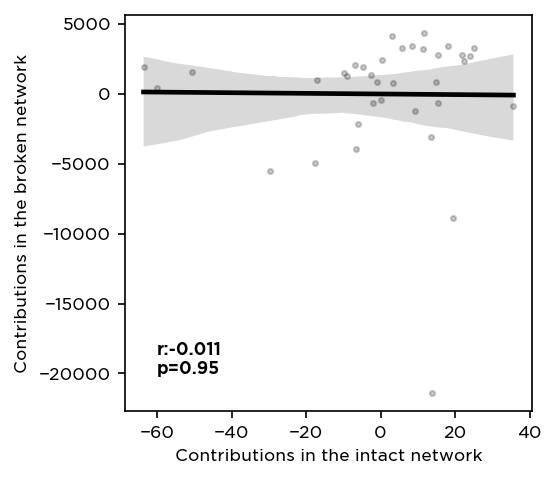

In [36]:
plt.figure(figsize=(3.5,3.5),dpi=150)
sns.regplot(x=shapley_sorted_by_index,y=baseline_shapley_sorted_by_index,color='k',scatter_kws={"s": 6,"alpha":0.2,"color":"k"})
plt.xlabel("Contributions in the intact network")
plt.ylabel("Contributions in the broken network")
plt.text(-60,-20000,f"r:{baseline_vs_intact[0]:.2}\np={baseline_vs_intact[1]:.3}",fontweight='bold')
plt.savefig(f"baseline_vs_intact.pdf",dpi=600,bbox_inches='tight')

/tmp/ipykernel_21470/2970516523.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=0.8)


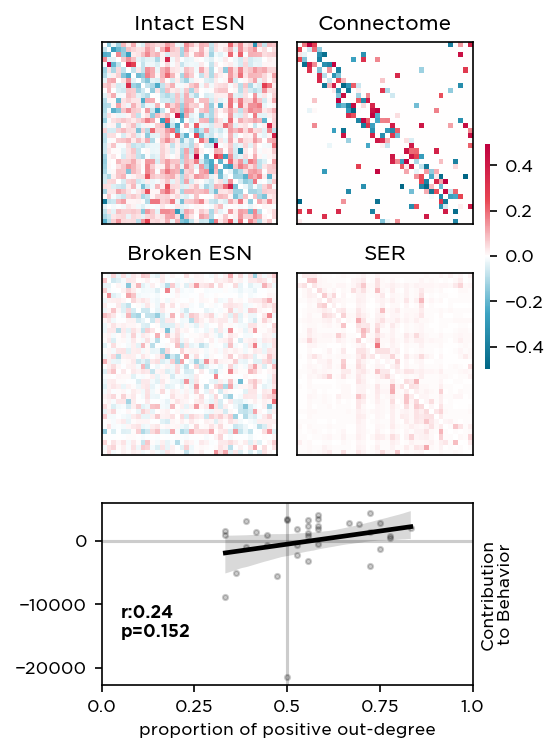

In [37]:
fig,axes = plt.subplot_mosaic(
    [['A', 'B',],
     ['C', 'D',],
     ['E', 'E']],figsize=(3.5,5),dpi=150)
cbar_ax = fig.add_axes([0.92, .51, .01, .3])

sns.heatmap(causal_influence_matrix,
            center=0,xticklabels=False,yticklabels=False,
            cmap=colormap,cbar=False,ax=axes['A'],vmax=vmax)
sns.heatmap(esn.W,center=0,xticklabels=False,yticklabels=False,
            cmap=colormap,cbar_kws={"shrink": .8},cbar_ax = cbar_ax,ax=axes['B'])

sns.heatmap(causal_influence_matrix_baseline,
            center=0,xticklabels=False,yticklabels=False,
            cmap=colormap,cbar=False,ax=axes['C'],vmax=vmax)
sns.heatmap(causal_influence_matrix_ser[causal_influence_matrix_ser>=0],
            center=0,xticklabels=False,yticklabels=False,
            cmap=colormap,cbar=False,ax=axes['D'],vmax=vmax)

sns.regplot(x=baseline_positive_signed_degree,y=baseline_shapley_sorted_by_index,color='k',ax = axes['E'],scatter_kws={"s": 6,"alpha":0.2,"color":"k"})

axes['E'].axhline(0,alpha=0.2,c='k')
axes['E'].axvline(0.5,alpha=0.2,c='k')
axes['E'].set_xlabel("proportion of positive out-degree")
axes['E'].set_ylabel("Contribution\nto Behavior")
axes['E'].text(0.05,-15000,f"r:{baseline_corr_with_behavior[0]:.2}\np={baseline_corr_with_behavior[1]:.3}",fontweight='bold')
axes['E'].yaxis.set_label_position("right")
axes['E'].set_xticks(np.linspace(0,1,5))
axes['E'].set_xticklabels([str(i) for i in np.linspace(0,1,5)])

axes['A'].title.set_text('Intact ESN')
axes['B'].title.set_text('Connectome')
axes['C'].title.set_text('Broken ESN')
axes['D'].title.set_text('SER')

for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)
fig.tight_layout(pad=0.8)

plt.savefig(f"ESNs SER Connectome.pdf",dpi=600,bbox_inches='tight')